# Introduction
This notebook is for the 2025 MLOps Zoomcamp 01-intro optional homework: predicting NYC taxi ride duration, and answering questions found [here](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2025/01-intro/homework.md)

Video guide for homework: https://www.youtube.com/watch?v=iRunifGSHFc&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK

Link to NYC taxi datasets and data dictionaries: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Data dictionary for yellow dataset: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
!python -V

Python 3.9.12


In [4]:
pd.__version__


'1.4.2'

In [40]:
!pip install scikit-learn

In [5]:
!pip install pyarrow

In [4]:
# Download green trip datasets
df1 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df2 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [5]:
df1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

Q1. There are 19 columns for Jan 2023 data.

Majority of trip types are type 1 (street hail) and a minority are dispatch.

In [87]:
# Computing duration
df1.loc[:,'duration'] = df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime']
df1['duration'].head()

0   0 days 00:08:26
1   0 days 00:06:19
2   0 days 00:12:45
3   0 days 00:09:37
4   0 days 00:10:50
Name: duration, dtype: timedelta64[ns]

In [88]:
# Convert to minutes
df1['duration'] = df1['duration'].apply(lambda x: x.total_seconds()/60)

In [83]:
df1['duration'].std()

42.594351241920904

In [89]:
df1['duration'].mean()

15.668995167332046

Q2. Standard deviation of trip duration in Jan 2023 is 42.59 minutes

In [9]:
df1.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

Majority of the trips are under 60 minutes. So we will filter to under 1 hour. There are some negative durations, which is likely erroneous.

In [10]:
# Removing the outliers
df1a = df1[(df1['duration']>=1) & (df1['duration']<=60)]

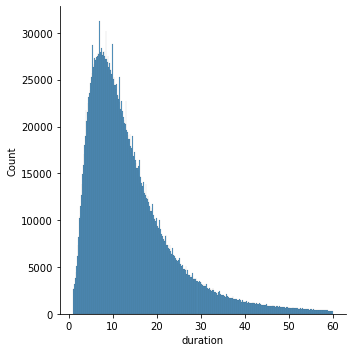

In [11]:
sns.displot(df1a, x = 'duration')
plt.show()

In [12]:
len(df1a)/len(df1)

0.9812202822125979

After dropping the outliers, 98.1% of the records are left.

In [90]:
df1a['duration'].std()

9.939385620145579

After removing the outliers, the standard deviation is 9.94 minutes

In [13]:
# Feature selection
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance'] # for homework, omit this feature

In [14]:
# Convert pickup and dropoff locations to categorical variables
df1a[categorical] = df1a[categorical].astype('category')

/tmp/ipykernel_52718/56295022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1a[categorical] = df1a[categorical].astype('category')


In [15]:
# Make training data into dictionaries
# train_dicts = df1a[categorical + numerical].to_dict(orient='records')
train_dicts = df1a[categorical].to_dict(orient='records')

In [16]:
# Make dictionaries into vectors (arrays)
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [17]:
X_train

<3009173x2 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

There are 2 dimensions in this matrix. 

In [18]:
target = 'duration'
y_train = df1a[target].values

In [19]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [70]:
# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [71]:
y_pred = lr.predict(X_train)

In [72]:
y_pred

array([14.62191938, 15.04631853, 14.95673981, ..., 13.94665725,
       14.45660364, 13.06955128])

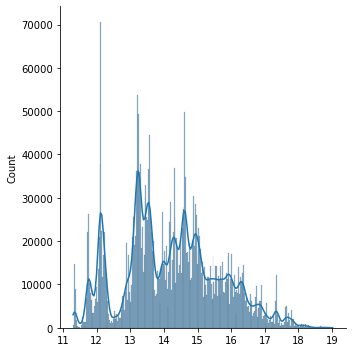

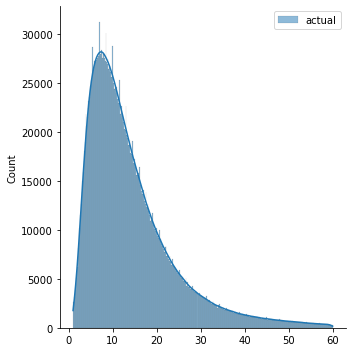

In [23]:
sns.displot(y_pred, label='prediction', kde=True)
sns.displot(y_train, label='actual', kde=True)
plt.legend()

In [73]:
# Calculate RMSE
def calc_rmse(pred, actual):
    rmse = mean_squared_error(pred, actual, squared=False)
    print(f"Root mean squared error: {rmse}")

In [74]:
calc_rmse(y_pred, y_train)

Root mean squared error: 9.835277713631873


In [75]:
# Making a reusable function to process the validation dataset
def process_df(df, categorical, numerical, target):
    # Computing duration
    df.loc[:,'duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    # Convert to minutes
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)
    # Remove outliers
    df = df[(df['duration']>=1) & (df['duration']<=60)]
    # Set aside target column
    target_vec = df[target].values
    
    # Select features
    df = df[categorical + numerical]
    
    # Convert categorical variables
    df[categorical] = df[categorical].astype('category')
    # Vectorize features and target
    dicts = df.to_dict(orient='records')
    dv = DictVectorizer()
    feat_vec = dv.fit_transform(dicts)
    
    return feat_vec, target_vec    

In [25]:
categorical, target

(['PULocationID', 'DOLocationID'], 'duration')

In [53]:
# Using Feb 2023 dataset as validation set (using only categorical variables)
numerical = []
X_val, y_val = process_df(df2, categorical, numerical, target)

In [76]:
y_pred = lr.predict(X_val)

In [77]:
rmse = calc_rmse(y_pred, y_val)

Root mean squared error: 9.963607595829973


In [78]:
# Save linear regressor
import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [79]:
# Try out Lasso Regression
from sklearn.linear_model import Lasso

lr = Lasso()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
calc_rmse(y_pred, y_val)


Root mean squared error: 9.963650461419611


In [80]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
calc_rmse(y_pred, y_val)

Root mean squared error: 9.963607818498394


In [81]:
# Try out Ridge Regression
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
calc_rmse(y_pred, y_val)

Root mean squared error: 9.96360759582997
